<img src='Quora-1.png'>

<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2> 1.2 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h1>2. Machine Learning Probelm </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h3> 2.1.2 Example Data point </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h3> 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

<h2> 2.3 Train and Test Construction </h2>

<p>  </p>
<p> We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with. </p>

<h1>3. Exploratory Data Analysis </h1>

In [85]:
import warnings
warnings.filterwarnings("ignore")

import sys
import os
import gc
import re
import time
import distance
import spacy
import sqlite3
import csv
import math

import datetime as dt
from tqdm import tqdm
from os import path
from PIL import Image

import numpy as np
import pandas as pd
from collections import Counter, defaultdict

import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from fuzzywuzzy import fuzz

from sklearn.preprocessing import MinMaxScaler

from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from mlxtend.classifier import StackingClassifier

from scipy.sparse import hstack
from scipy.sparse import coo_matrix

from sqlalchemy import create_engine # database connection

import xgboost as xgb

<h2> 3.1 Reading data and basic stats </h2>

In [3]:
df = pd.read_csv("train.csv")

print("Number of data points:",df.shape[0])

Number of data points: 404290


In [4]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

<h2> 3.2 Distribution of data points among output classes</h2>

Number of duplicate(smilar) and non-duplicate(non similar) questions

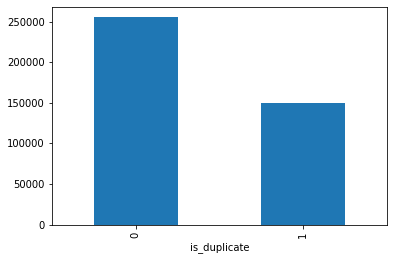

In [6]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [7]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))

~> Total number of question pairs for training:
   404290


In [8]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


<h3> 3.2.1 Number of unique questions </h3>

In [9]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



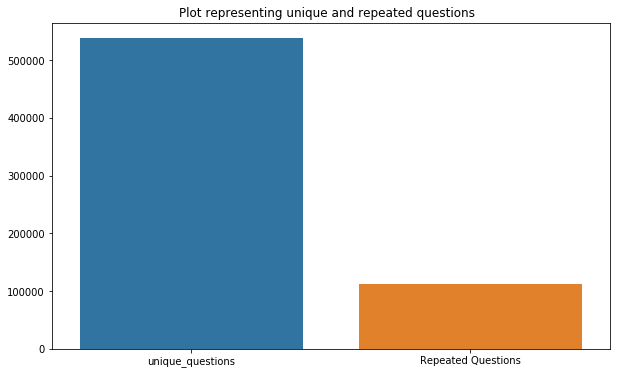

In [10]:

x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

<h3>3.2.2 Checking for Duplicates </h3>

In [11]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


<h3> 3.2.3 Number of occurrences of each question </h3>

Maximum number of times a single question is repeated: 157



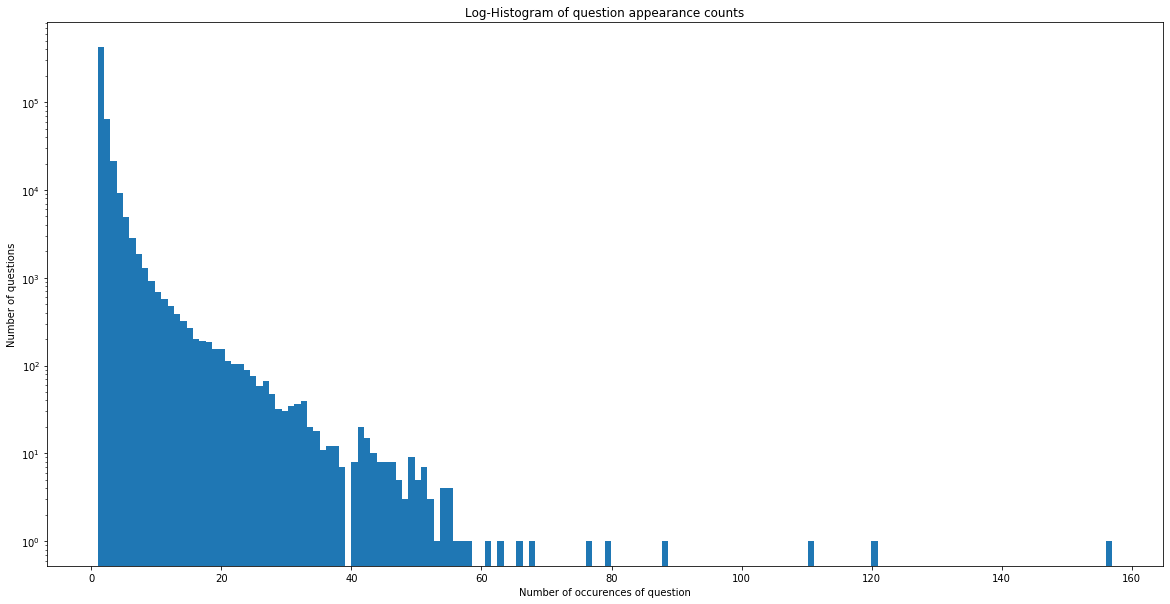

In [12]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

<h3> 3.2.4 Checking for NULL values </h3>

In [13]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


- There are two rows with null values in question2 

In [14]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


<h2>3.3 Basic Feature Extraction (before cleaning) </h2>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [15]:
from sklearn.utils import resample
df =resample(df,n_samples=100000)

In [16]:

df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
df['q1len'] = df['question1'].str.len() 
df['q2len'] = df['question2'].str.len()
df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

def normalized_word_Common(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)
df['word_Common'] = df.apply(normalized_word_Common, axis=1)

def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * (len(w1) + len(w2))
df['word_Total'] = df.apply(normalized_word_Total, axis=1)

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
df['word_share'] = df.apply(normalized_word_share, axis=1)

df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])



print(df.head())

            id    qid1    qid2  \
314140  314140  438836  438837   
8949      8949   17417   17418   
29895    29895   55266   55267   
192599  192599  128849  175011   
33510    33510   14063   61550   

                                                question1  \
314140  How can an Indian guy make his parents accept ...   
8949                            How the memory functions?   
29895                               Why do I love people?   
192599        Which is the best book for data structures?   
33510   What is the deep/dark web and how do you acces...   

                                                question2  is_duplicate  \
314140  How do I get Indian parents to accept my forei...             1   
8949                             How do we have memories?             0   
29895                                 Why do people love?             0   
192599  What is the best book on data-structures for b...             1   
33510   What are some positive uses for the Dark/ Dee

<h3> 3.3.1 Analysis of some of the extracted features </h3>

- Here are some questions have only one single words.

In [17]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 14
Number of Questions with minimum length [question2] : 4


<h4> 3.3.1.1 Feature: word_share </h4>

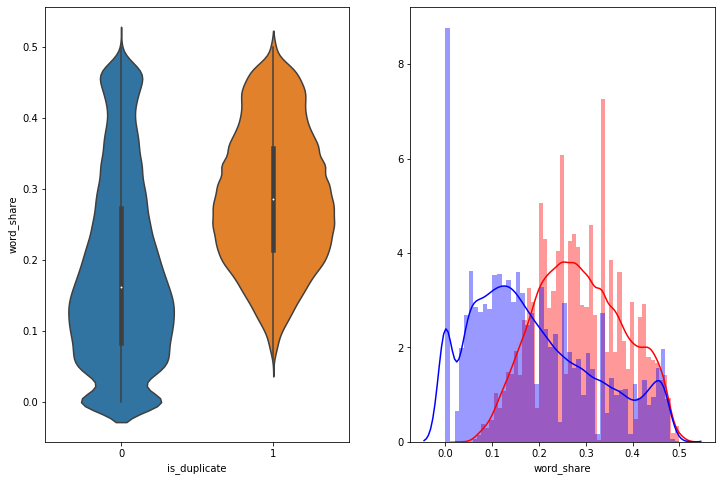

In [18]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

<h4> 3.3.1.2 Feature: word_Common </h4>

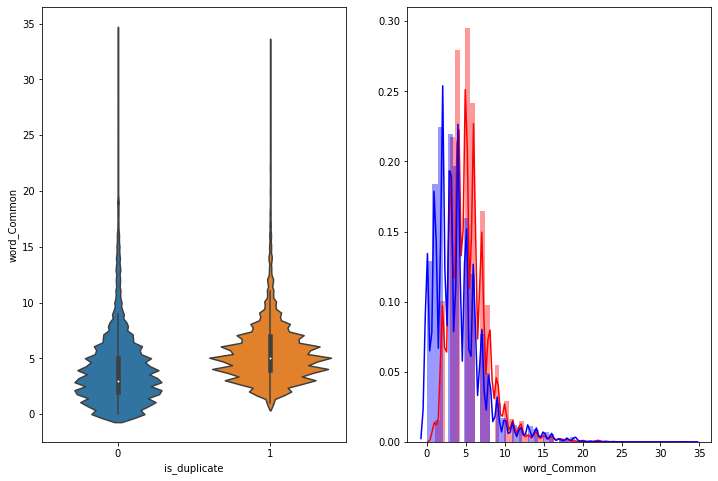

In [19]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>

<h2>3.4 EDA: Advanced Feature Extraction. </h2>

In [20]:
#https://stackoverflow.com/questions/12468179/unicodedecodeerror-utf8-codec-cant-decode-byte-0x9c

df = df.fillna('')    


In [21]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
314140,314140,438836,438837,How can an Indian guy make his parents accept ...,How do I get Indian parents to accept my forei...,1,1,1,69,60,12,11,6.0,22.0,0.272727,2,0
8949,8949,17417,17418,How the memory functions?,How do we have memories?,0,1,1,25,24,4,5,1.0,9.0,0.111111,2,0


<h2> 3.5 Preprocessing of Text </h2>

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

- Function to Compute and get the features : With 2 parameters of Question 1 and Question 2

In [22]:
# To get the results in 4 decimal points
SAFE_DIV = 0.0001 

STOP_WORDS = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

<h2> 3.6 Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>
- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>
- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>
- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>
- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage  <br>
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>
- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage  <br>
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>
- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage  <br>
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>
- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage  <br>
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>
- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))

In [23]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [24]:
len(df)

100000

In [25]:
%%time
print("Extracting features for train:")
#df = pd.read_csv("train.csv")
df = extract_features(df)
#df.to_csv("nlp_features_train.csv", index=False)
df.head(2)

Extracting features for train:
token features...
fuzzy features..
Wall time: 17min 1s


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
314140,314140,438836,438837,how can an indian guy make his parents accept ...,how do i get indian parents to accept my forei...,1,1,1,69,60,...,0.499996,1.0,1.0,1.0,11.5,85,74,74,72,0.327869
8949,8949,17417,17418,how the memory functions,how do we have memories,0,1,1,25,24,...,0.199996,0.0,1.0,1.0,4.5,55,55,60,58,0.280000


In [26]:
def plot_confusion_matrix(y_test, predicted_y):
    C = confusion_matrix(y_test,predicted_y)   
    A =(((C.T)/(C.sum(axis=1))).T)  
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))

    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")

    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")

    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")

    plt.show()

<h1>4. Featurizing text data with tfidf vectors </h1>

In [27]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
314140,314140,438836,438837,how can an indian guy make his parents accept ...,how do i get indian parents to accept my forei...,1,1,1,69,60,...,0.499996,1.0,1.0,1.0,11.5,85,74,74,72,0.327869
8949,8949,17417,17418,how the memory functions,how do we have memories,0,1,1,25,24,...,0.199996,0.0,1.0,1.0,4.5,55,55,60,58,0.280000
29895,29895,55266,55267,why do i love people,why do people love,0,1,1,21,19,...,0.799984,0.0,1.0,1.0,4.5,100,95,68,68,0.400000
192599,192599,128849,175011,which is the best book for data structures,what is the best book on data structures for b...,1,5,2,43,55,...,0.699993,0.0,0.0,2.0,9.0,92,81,77,88,0.409091
33510,33510,14063,61550,what is the deep dark web and how do you acces...,what are some positive uses for the dark deep...,0,4,1,51,51,...,0.416663,0.0,1.0,2.0,11.0,62,65,40,41,0.115385


In [28]:
y_true = df['is_duplicate']

In [29]:
X_train,X_test, y_train, y_test = train_test_split(df, y_true, stratify=y_true, test_size=0.3)

<br/>
<br/>
<h3> 5.7.1 Perform TF-IDF Tokenization on columns- 'question1', 'question2' </h3>

In [30]:
# Instanciate Tfidf Vectorizer 
tfidfVectorizer_question1 = TfidfVectorizer()

question1_train = tfidfVectorizer_question1.fit_transform(X_train['question1'].values.astype('U'))
question1_test = tfidfVectorizer_question1.transform(X_test['question1'].values.astype('U'))

In [31]:
print("Found {0} features from question1 column".format(len(tfidfVectorizer_question1.get_feature_names())))

Found 29892 features from question1 column


In [32]:
# Instanciate Tfidf Vectorizer 
tfidfVectorizer_question2 = TfidfVectorizer()

question2_train = tfidfVectorizer_question2.fit_transform(X_train['question2'].values.astype('U'))
question2_test = tfidfVectorizer_question2.transform(X_test['question2'].values.astype('U'))

In [33]:
print("Found {0} features from question2 column".format(len(tfidfVectorizer_question2.get_feature_names())))

Found 27942 features from question2 column


In [73]:
type(question1_train)

scipy.sparse.csr.csr_matrix

In [34]:
# Combine all the features in question1 and question2
question1_question2_train = hstack((question1_train,question2_train))
question1_question2_test = hstack((question1_test,question2_test))

In [35]:
type(question1_question2_train)

scipy.sparse.coo.coo_matrix

In [36]:
# Drop unnecessary question1 and question2 columns
X_train.drop(['question1','question2'], axis=1, inplace=True)
X_test.drop(['question1','question2'], axis=1, inplace=True)

In [37]:
# Combine all basic, advance and tfidf features
X_train = hstack((X_train, question1_question2_train),format="csr",dtype='float64')
X_test = hstack((X_test, question1_question2_test),format="csr",dtype='float64')

In [38]:
X_train.shape

(70000, 57864)

<br/>
<br/>
<h2> 5.8 Apply ML Models</h2>

<h3> 5.8.1 Random Model</h3>

Log loss on Test Data using Random Model 0.8864978405217349


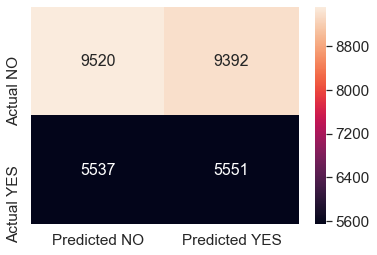

In [39]:
predicted_y = np.zeros((len(y_test),2))
test_len = len(y_test)
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

y_pred =np.argmax(predicted_y, axis=1)
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
df_cm.columns = ['Predicted NO','Predicted YES']
df_cm = df_cm.rename({0: 'Actual NO', 1: 'Actual YES'})
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

<br/>
<br/>
<h3> 5.8.2 Logistic Regression with hyperparameter tuning</h3>

In [40]:
print(X_test.shape)
print(X_train.shape)
print(y_train.shape)
print(y_test.shape)

(30000, 57864)
(70000, 57864)
(70000,)
(30000,)


In [41]:
X_train = X_train [:,:X_test.shape[1]]

In [42]:
print(X_train.shape)

(70000, 57864)


For values of alpha =  1e-05 The log loss is: 9.958680527199245
For values of alpha =  0.0001 The log loss is: 21.586735246819178
For values of alpha =  0.001 The log loss is: 10.115023318516853
For values of alpha =  0.01 The log loss is: 11.423124646343462
For values of alpha =  0.1 The log loss is: 21.628078206211534
For values of alpha =  1 The log loss is: 10.089336960990947
For values of alpha =  10 The log loss is: 11.32079836964584
For values of alpha =  100 The log loss is: 9.81314819901735
For values of alpha =  1000 The log loss is: 1.587892275132105
For values of alpha =  10000 The log loss is: 0.8683546916811287


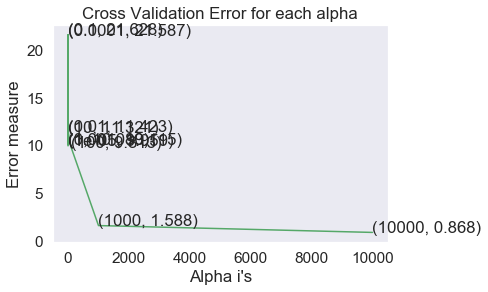

Wall time: 8min 51s


In [43]:
%%time
alpha = [10 ** x for x in range(-5, 5)] # hyperparam for SGD classifier.
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [44]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=10000, average=False,
                                                    class_weight=None,
                                                    early_stopping=False,
                                                    epsilon=0.1, eta0=0.0,
                                                    fit_intercept=True,
                                                    l1_ratio=0.15,
                                                    learning_rate='optimal',
                                                    loss='log', max_iter=1000,
                                                    n_iter_no_change=5,
                                                    n_jobs=None, penalty='l2',
                                                    power_t=0.5,
                                                    random_state=42,
                                                    shuffle=True, tol=0.001,
                                           

For values of best alpha =  10000 The train log loss is: 0.6030490225913667
For values of best alpha =  10000 The test log loss is: 0.6018797339174758
Total number of data points : 30000


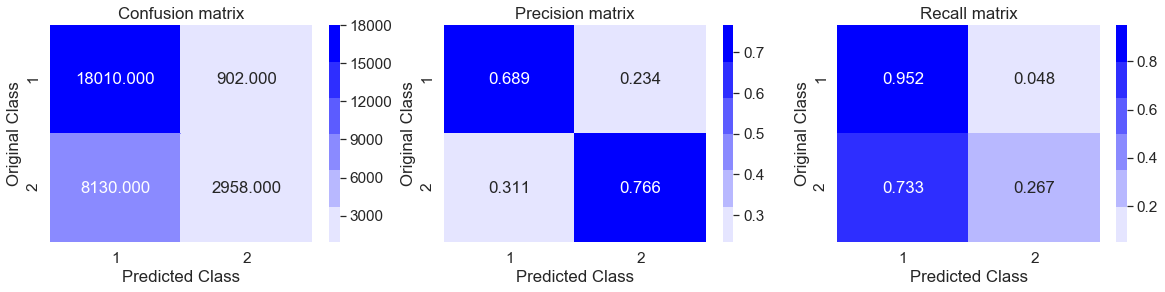

In [45]:
predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<br/>
<br/>
<h3> 5.8.3 Linear SVM with hyperparameter tuning </h3>

For values of alpha =  1e-05 The log loss is: 0.6587424509741797
For values of alpha =  0.0001 The log loss is: 0.6587424509741797
For values of alpha =  0.001 The log loss is: 0.6587424509741797
For values of alpha =  0.01 The log loss is: 0.6587424509741797
For values of alpha =  0.1 The log loss is: 0.6587424509741797
For values of alpha =  1 The log loss is: 0.5855745125635411
For values of alpha =  10 The log loss is: 0.6587424509741797
For values of alpha =  100 The log loss is: 0.6587424509741797
For values of alpha =  1000 The log loss is: 0.6587424509741797
For values of alpha =  10000 The log loss is: 0.6587424509741797


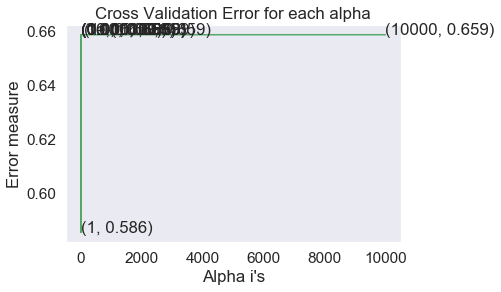

Wall time: 15min 35s


In [50]:
%%time
alpha = [10 ** x for x in range(-5, 5)] # hyperparam for SGD classifier.
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [51]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha= 1, penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=1, average=False,
                                                    class_weight=None,
                                                    early_stopping=False,
                                                    epsilon=0.1, eta0=0.0,
                                                    fit_intercept=True,
                                                    l1_ratio=0.15,
                                                    learning_rate='optimal',
                                                    loss='hinge', max_iter=1000,
                                                    n_iter_no_change=5,
                                                    n_jobs=None, penalty='l1',
                                                    power_t=0.5,
                                                    random_state=42,
                                                    shuffle=True, tol=0.001,
                                             

For values of best alpha =  1 The train log loss is: 0.5863220436240042
For values of best alpha =  1 The test log loss is: 0.5855745125635411
Total number of data points : 30000


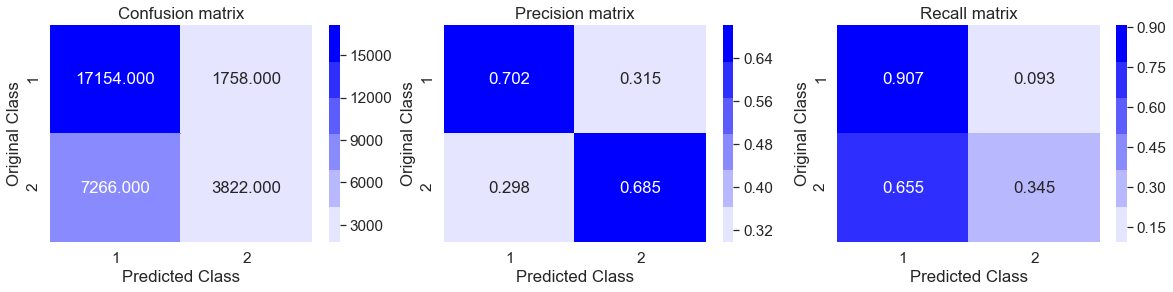

In [52]:
predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<br/>
<br/>
<h3> 5.8.4 XGBoost Model </h3>

In [53]:
X_train,X_test, y_train, y_test = train_test_split(df, y_true, stratify=y_true, test_size=0.3)

In [55]:
import pickle

In [60]:
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model_q1 = TfidfVectorizer()
tfidf_model_q2 = TfidfVectorizer()

tfidf_model_q1.fit(X_train['question1'].values.astype('U'))
# we are converting a dictionary with word as a key, and the idf as a value
dictionary1 = dict(zip(tfidf_model_q1.get_feature_names(), list(tfidf_model_q1.idf_)))
tfidf_words_q1 = set(tfidf_model_q1.get_feature_names())

tfidf_model_q2.fit(X_train['question2'].values.astype('U'))
# we are converting a dictionary with word as a key, and the idf as a value
dictionary2 = dict(zip(tfidf_model_q2.get_feature_names(), list(tfidf_model_q2.idf_)))
tfidf_words_q2 = set(tfidf_model_q2.get_feature_names())

In [61]:
# compute average word2vec for each review.
train_tfidf_w2v_question1 = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['question1'].values): # for each review/sentence
    vector = np.zeros(50) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words_q1):
            vec = model[word][:50] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary1[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    train_tfidf_w2v_question1.append(vector)

print("Train matrix:")
print(len(train_tfidf_w2v_question1))
print(len(train_tfidf_w2v_question1[0]))
print('='*50)



test_tfidf_w2v_question1 = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['question1'].values): # for each review/sentence
    vector = np.zeros(50) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words_q1):
            vec = model[word][:50] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary1[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    test_tfidf_w2v_question1.append(vector)

print("Test matrix:")
print(len(test_tfidf_w2v_question1))
print(len(test_tfidf_w2v_question1[0]))
print('='*50)

100%|██████████████████████████████████████████████████████████████████████████| 70000/70000 [00:07<00:00, 9052.61it/s]


Train matrix:
70000
50


100%|██████████████████████████████████████████████████████████████████████████| 30000/30000 [00:03<00:00, 9392.80it/s]


Test matrix:
30000
50


In [62]:
# compute average word2vec for each review.
train_tfidf_w2v_question2 = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['question2'].values.astype('U')): # for each review/sentence
    vector = np.zeros(50) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words_q2):
            vec = model[word][:50] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary2[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    train_tfidf_w2v_question2.append(vector)

print("Train matrix:")
print(len(train_tfidf_w2v_question2))
print(len(train_tfidf_w2v_question2[0]))
print('='*50)



test_tfidf_w2v_question2 = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['question2'].values.astype('U')): # for each review/sentence
    vector = np.zeros(50) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words_q2):
            vec = model[word][:50] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary2[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    test_tfidf_w2v_question2.append(vector)

print("Test matrix:")
print(len(test_tfidf_w2v_question2))
print(len(test_tfidf_w2v_question2[0]))
print('='*50)

100%|██████████████████████████████████████████████████████████████████████████| 70000/70000 [00:07<00:00, 9218.18it/s]


Train matrix:
70000
50


100%|██████████████████████████████████████████████████████████████████████████| 30000/30000 [00:03<00:00, 8447.93it/s]


Test matrix:
30000
50


In [74]:
train_tfidf_w2v_question2 = np.array(train_tfidf_w2v_question2)
test_tfidf_w2v_question2 = np.array(test_tfidf_w2v_question2)
train_tfidf_w2v_question1 = np.array(train_tfidf_w2v_question1)
test_tfidf_w2v_question1 = np.array(test_tfidf_w2v_question1)

In [84]:
train_tfidf_w2v_question2 .shape

(70000, 50)

In [88]:
train_tfidf_w2v_question1 = coo_matrix(train_tfidf_w2v_question1)
train_tfidf_w2v_question2 = coo_matrix(train_tfidf_w2v_question2)
test_tfidf_w2v_question1 = coo_matrix(test_tfidf_w2v_question1)
test_tfidf_w2v_question2 = coo_matrix(test_tfidf_w2v_question2)

In [89]:
# Combine all the features in question1 and question2
question1_question2_train = hstack((train_tfidf_w2v_question1,train_tfidf_w2v_question2)).tocsr()
question1_question2_test = hstack((test_tfidf_w2v_question1,test_tfidf_w2v_question2)).tocsr()

In [90]:
type(question1_question2_train)

scipy.sparse.csr.csr_matrix

In [91]:
# Drop unnecessary question1 and question2 columns
X_train.drop(['question1','question2'], axis=1, inplace=True)
X_test.drop(['question1','question2'], axis=1, inplace=True)

In [92]:
# Combine all basic, advance and tfidf features
X_train = hstack((X_train, question1_question2_train),format="csr",dtype='float64')
X_test = hstack((X_test, question1_question2_test),format="csr",dtype='float64')

In [93]:
print(X_train.shape)
print(X_test.shape)

(70000, 130)
(30000, 130)


In [94]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold
import xgboost as xgb


In [95]:
%%time
n_estimators = [100, 500, 700, 1100, 1300]
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.3]
colsample_bytree = [0.1, 0.5, 0.7 , 0.9, 1]
subsample = [0.1,0.3,0.5,0.7,1]

def hyperparameter_tunning(X,Y):
    param_grid = dict(learning_rate=learning_rate,
                      n_estimators=n_estimators,
                      colsample_bytree = colsample_bytree,
                      subsample = subsample)
    
    model = XGBClassifier(nthread=-1)
    kfold = StratifiedKFold(n_splits=2, shuffle=True)
    random_search = RandomizedSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
    random_result = random_search.fit(X,Y)
    
    # Summarize results
    print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))
    print()
    means = random_result.cv_results_['mean_test_score']
    stds = random_result.cv_results_['std_test_score']
    params = random_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
        
    return random_result       


Wall time: 0 ns


In [96]:
start = dt.datetime.now()

# Tune hyperparameter values
random_result = hyperparameter_tunning(X_train,y_train)

print("\nTimeTaken: ",dt.datetime.now() - start)

Best: -0.000057 using {'subsample': 1, 'n_estimators': 100, 'learning_rate': 0.3, 'colsample_bytree': 1}

-0.501581 (0.000034) with: {'subsample': 0.5, 'n_estimators': 100, 'learning_rate': 0.01, 'colsample_bytree': 0.1}
-0.000057 (0.000000) with: {'subsample': 1, 'n_estimators': 100, 'learning_rate': 0.3, 'colsample_bytree': 1}
-0.000224 (0.000000) with: {'subsample': 0.7, 'n_estimators': 1100, 'learning_rate': 0.01, 'colsample_bytree': 0.7}
-0.000110 (0.000000) with: {'subsample': 0.5, 'n_estimators': 1100, 'learning_rate': 0.1, 'colsample_bytree': 0.5}
-0.000872 (0.000000) with: {'subsample': 0.1, 'n_estimators': 700, 'learning_rate': 0.01, 'colsample_bytree': 1}
-0.001555 (0.000001) with: {'subsample': 0.7, 'n_estimators': 100, 'learning_rate': 0.1, 'colsample_bytree': 0.5}
-0.000206 (0.000006) with: {'subsample': 0.3, 'n_estimators': 1100, 'learning_rate': 0.1, 'colsample_bytree': 0.1}
-0.000077 (0.000000) with: {'subsample': 0.7, 'n_estimators': 700, 'learning_rate': 0.1, 'colsam

In [101]:
xGBClassifier = XGBClassifier(max_depth=3, 
                              learning_rate=0.3, 
                              n_estimators=100,
                              subsample=1,
                              colsample_bytree= 1, 
                              nthread=-1)
xGBClassifier

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [104]:
start = dt.datetime.now()
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 3
params['colsample_bytree'] = 1
params['n_estimators'] = 100
params['subsample'] = 1
params['learning_rate'] = 0.3
params['nthread'] = -1
params['silent'] = 1

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist,verbose_eval= False,early_stopping_rounds=20)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
print("\nTime Taken: ",dt.datetime.now() - start)

The test log loss is: 2.8158302704287052e-05

Time Taken:  0:00:47.623612


Total number of data points : 30000


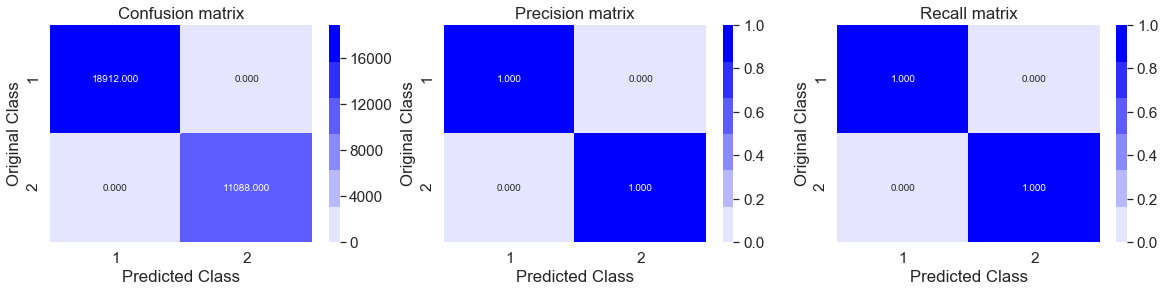

In [105]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))

plot_confusion_matrix(y_test, predicted_y)

<br/>
<br/>
<br/>
<h1> Conclusion </h1>

In [108]:
from prettytable import PrettyTable
ptable = PrettyTable()
ptable.title = " Model Comparision "
ptable.field_names = ['Dataset Size', 'Model Name', 'Tokenizer','Hyperparameter Tunning', 'Test Log Loss']
ptable.add_row(["\n","\n","\n","\n","\n"])
ptable.add_row(["~ 100K","Random","TFIDF","NA","0.886"])
ptable.add_row(["~ 100K","Logistic Regression","TFIDF","Done","0.60"])
ptable.add_row(["~ 100K","Linear SVM","TFIDF","Done","0.585"])
ptable.add_row(["~ 100K","XGBoost","TFIDF","Done","2.85 e-05"])
print(ptable)

+--------------+---------------------+-----------+------------------------+---------------+
| Dataset Size |      Model Name     | Tokenizer | Hyperparameter Tunning | Test Log Loss |
+--------------+---------------------+-----------+------------------------+---------------+
|              |                     |           |                        |               |
|              |                     |           |                        |               |
|    ~ 100K    |        Random       |   TFIDF   |           NA           |     0.886     |
|    ~ 100K    | Logistic Regression |   TFIDF   |          Done          |      0.60     |
|    ~ 100K    |      Linear SVM     |   TFIDF   |          Done          |     0.585     |
|    ~ 100K    |       XGBoost       |   TFIDF   |          Done          |   2.85 e-05   |
+--------------+---------------------+-----------+------------------------+---------------+


<h4> As dimension increases Logistic Regression and Linear SVM, starts to perform well,whereas XGBoost produces almost same results after hyperparameter tunning(This can be improved by tunnig more hyperparameters) </h4>

### Step By Step Process of Model Implementation




#### Tokenizer: TFIDF
1. First we apply random model and get log loss of 0.88 which means for other models log loss should be lesser than this value
2. Next we have applied for logistic Regression and linear SBM , for which we have log loss of 0.60 and 0.585 respectively, for logistic regression log loss can be reduced by increasing number of dimensions in data(from 100K to 400K)
3. XGBoost has minimum log loss among all models

Finally for this case study, we conclude that on low dimesion data,we will use hyperparameter tuned 'XGBoost' model and for high dimension data we will use either 'Linear SVM' or 'Logistic Regression'